#Setup & Import

In [ ]:
pathName      = "/content/drive/My Drive/" 
pathNameData  = pathName + "Datasets/" 
pathNameTrain = pathName + "DataTrain/"
prefix        = '_2022_'


# Вариант 1 - повтор примера Keras c используемым англоязычным датасетом
https://keras.io/examples/nlp/ner_transformers/

## Named Entity Recognition using Transformers

**Author:** [Varun Singh](https://www.linkedin.com/in/varunsingh2/)<br>
**Date created:** Jun 23, 2021<br>
**Last modified:** Jun 24, 2021<br>
**Description:** NER using the Transformers and data from CoNLL 2003 shared task.

## Introduction

Named Entity Recognition (NER) is the process of identifying named entities in text.
Example of named entities are: "Person", "Location", "Organization", "Dates" etc. NER is
essentially a token classification task where every token is classified into one or more
predetermined categories.

In this exercise, we will train a simple Transformer based model to perform NER. We will
be using the data from CoNLL 2003 shared task. For more information about the dataset,
please visit [the dataset website](https://www.clips.uantwerpen.be/conll2003/ner/).
However, since obtaining this data requires an additional step of getting a free license, we will be using
HuggingFace's datasets library which contains a processed version of this dataset.

The shared task of CoNLL-2003 concerns language-independent named entity recognition. We will concentrate on four types of named entities: 
- persons, 
- locations, 
- organizations and 
- names of miscellaneous entities that do not belong to the previous three groups. 

## Install the open source datasets library from HuggingFace

In [ ]:
!pip3 install datasets
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py

     |████████████████████████████████| 264 kB 23.8 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 243 kB 53.2 MB/s 
     |████████████████████████████████| 118 kB 55.4 MB/s 
--2021-08-27 12:40:01--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py’

conlleval.py        100%[===================>]   7.33K  --.-KB/s    in 0s      

2021-08-27 12:40:01 (86.0 MB/s) - ‘conlleval.py’ saved [7502/7502]



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
from collections import Counter
from conlleval import evaluate

We will be using the transformer implementation from this fantastic
[example](https://keras.io/examples/nlp/text_classification_with_transformer/).

Let's start by defining a `TransformerBlock` layer:

In [ ]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


Next, let's define a `TokenAndPositionEmbedding` layer:

In [ ]:

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings


## Build the NER model class as a `keras.Model` subclass

In [ ]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32
    ):
        super(NERModel, self).__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x


## Load the CoNLL 2003 dataset from the datasets library and process it

In [ ]:
conll_data = load_dataset("conll2003")

Downloading:   0%|          | 0.00/2.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/146k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6. Subsequent calls will reuse this data.


We will export this data to a tab-separated file format which will be easy to read as a
`tf.data.Dataset` object.

In [ ]:
def export_to_file(export_file_path, data):
    with open(export_file_path, "w") as f:
        for record in data:
            ner_tags = record["ner_tags"]
            tokens = record["tokens"]
            f.write(
                str(len(tokens))
                + "\t"
                + "\t".join(tokens)
                + "\t"
                + "\t".join(map(str, ner_tags))
                + "\n"
            )


os.mkdir("data")
export_to_file("./data/conll_train.txt", conll_data["train"])
export_to_file("./data/conll_val.txt", conll_data["validation"])

## Make the NER label lookup table

NER labels are usually provided in IOB, IOB2 or IOBES formats. Checkout this link for
more information:
[Wikipedia](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging))

Note that we start our label numbering from 1 since 0 will be reserved for padding. We
have a total of 10 labels: 9 from the NER dataset and one for padding.

Inside–outside–beginning (tagging) - **Хорошее дополнение к занятию**

The IOB format (short for inside, outside, beginning) is a common tagging format for tagging tokens in a chunking task in computational linguistics (ex. named-entity recognition).[1] It was presented by Ramshaw and Marcus in their paper "Text Chunking using Transformation-Based Learning", 1995[2] 

The **I- prefix** before a tag indicates that the tag is inside a chunk. (тег находится внутри фрагмента (chunk))

An **O tag** indicates that a token belongs to no chunk. (токен не принаджелжит ни одному фрагменту)

The **B- prefix** before a tag indicates that the tag is the beginning of a chunk that immediately follows another chunk without O tags between them (тег-это начало фрагмента, который сразу следует за другим фрагментом без тегов O между ними).
It is used only in that case: when a chunk comes after an O tag, the first token of the chunk takes the I- prefix.

Another similar format which is widely used is IOB2 format, which is the same as the IOB format except that the **B- tag** is used in the beginning of every chunk (i.e. all chunks start with the B- tag).

A readable introduction to entity tagging is given in Bob Carpenter's blog post, "Coding Chunkers as Taggers".[3]
 "Coding Chunkers as Taggers: IO, BIO, BMEWO, and BMEWO+" 

An example with IOB format:

- Alex I-PER
- is O
- going O
- to O
- Los I-LOC
- Angeles I-LOC
- in O
- California I-LOC

Notice how "Alex", "Los" and "California", although first tokens of their chunk, have the "I-" prefix.

The same example after filtering out stop words:

- Alex I-PER
- going O
- Los I-LOC
- Angeles I-LOC
- California B-LOC

Notice how "California" now has the "B-" prefix, because it immediately follows another LOC chunk.

The same example with IOB2 format (with tagging unaffected by stop word filtering):

- Alex B-PER
- is O
- going O
- to O
- Los B-LOC
- Angeles I-LOC
- in O
- California B-LOC

Related tagging schemes sometimes include "START/END: This consists of the tags B, E, I, S or O where S is used to represent a chunk containing a single token. Chunks of length greater than or equal to two always start with the B tag and end with the E tag."[4]

Other Tagging Scheme's include BIOES/BILOU, where 'E' and 'L' denotes Last or Ending character is such a sequence and 'S' denotes Single element or 'U' Unit element.

An Example with BIOES format:

- Alex S-PER
- is O
- going O
- with O
- Marty B-PER
- A. I-PER
- Rick E-PER
- to O
- Los B-LOC
- Angeles E-LOC

https://lingpipe-blog.com/2009/10/14/coding-chunkers-as-taggers-io-bio-bmewo-and-bmewo/

IO Encoding
The simplest encoding is the IO encoding, which tags each token as either being in (I_X) a particular type of named entity type X or in no entity (O). This encoding is defective in that it can’t represent two entities next to each other, because there’s no boundary tag.

BIO Encoding
The “industry standard” encoding is the BIO encoding (anyone know who invented this encoding?). It subdivides the in tags as either being begin-of-entity (B_X) or continuation-of-entity (I_X).

BMEWO Encoding
The BMEWO encoding further distinguishes end-of-entity (E_X) tokens from mid-entity tokens (M_X), and adds a whole new tag for single-token entities (W_X). I believe the BMEWO encoding was introduced in Andrew Borthwick’s NYU thesis and related papers on “max entropy” named entity recognition around 1998, following Satoshi Sekine’s similar encoding for decision tree named entity recognition. (Satoshi and David Nadeau just released their Survey of NER.)

BMEWO+ Encoding
I introduced the BMEWO+ encoding for the LingPipe HMM-based chunkers. Because of the conditional independence assumptions in HMMs, they can’t use information about preceding or following words. Adding finer-grained information to the tags themselves implicitly encodes a kind of longer-distance information. This allows a different model to generate words after person entities (e.g. John said), for example, than generates words before location entities (e.g. in Boston). The tag transition constraints (B_X must be followed by M_X or E_X, etc.) propagate decisions, allowing a strong location-preceding word to trigger a location.

Note that it also adds a begin and end of sequence subcategorization to the out tags. This helped reduce the confusion between English sentence capitalization and proper name capitalization.

https://habr.com/ru/company/abbyy/blog/449514/
NLP. Основы. Техники. Саморазвитие. Часть 2: NER
Блог компании ABBYY

Важно отметить, что в sentence based approach кроме категориальных признаков, определяемых по словам, используется признак — сдвиг относительно токена, метку которого мы пытаемся определить. Значение этого признака для токена номер i будет i-core, где core — номер токена, метку которого мы пытаемся определить в данный момент (этот признак тоже считается категориальным, и вектора для него вычисляются точно так же, как и для остальных).

Следующий этап нахождения признаков токена — умножение каждого image на матрицу image, которая называется Lookup Table (таким образом булевы вектора “превращаются” в непрерывные). Напомним, что каждый из image — булев вектор, в котором на одном месте стоит 1, а на остальных местах – 0. Таким образом при умножении image на image, происходит выбор одной из строк в нашей матрице. Эта строка и является эмбеддингом соответствующего признака токена. Матрицы image (где i может принимать значения от 1 до K) – это параметры нашей сети, которые мы обучаем вместе с остальными слоями нейросети.

...

мы с нуля учим эмбеддинг не очень большого размера. Это в точности Lookup-таблицы

In [ ]:
def make_tag_lookup_table():
    iob_labels = ["B", "I"]
    ner_labels = ["PER", "ORG", "LOC", "MISC"]
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    all_labels = ["[PAD]", "O"] + all_labels
    return dict(zip(range(0, len(all_labels) + 1), all_labels))


mapping = make_tag_lookup_table()
print(mapping)

{0: '[PAD]', 1: 'O', 2: 'B-PER', 3: 'I-PER', 4: 'B-ORG', 5: 'I-ORG', 6: 'B-LOC', 7: 'I-LOC', 8: 'B-MISC', 9: 'I-MISC'}


Get a list of all tokens in the training dataset. This will be used to create the
vocabulary.

In [ ]:
all_tokens = sum(conll_data["train"]["tokens"], [])
all_tokens_array = np.array(list(map(str.lower, all_tokens)))

counter = Counter(all_tokens_array)
print(len(counter))

num_tags = len(mapping)
vocab_size = 20000

# We only take (vocab_size - 2) most commons words from the training data since
# the `StringLookup` class uses 2 additional tokens - one denoting an unknown
# token and another one denoting a masking token
vocabulary = [token for token, count in counter.most_common(vocab_size - 2)]

# The StringLook class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(
    vocabulary=vocabulary
)

21009


In [ ]:
print(all_tokens[:10], "\n", counter,"\n", vocabulary[:10]  )

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.', 'Peter'] 
 Counter({'the': 8390, '.': 7374, ',': 7290, 'of': 3815, 'in': 3621, 'to': 3424, 'a': 3199, 'and': 2872, '(': 2861, ')': 2861, '"': 2178, 'on': 2092, 'said': 1849, "'s": 1566, 'for': 1465, '1': 1421, '-': 1243, 'at': 1146, 'was': 1095, '2': 973, '0': 945, '3': 932, 'with': 867, 'that': 797, 'he': 792, 'from': 768, 'it': 762, 'by': 726, 'is': 694, ':': 691, 'as': 630, '4': 581, 'had': 561, 'his': 559, 'has': 559, 'but': 545, 'an': 542, 'not': 541, 'were': 531, 'be': 525, 'after': 509, 'have': 502, 'first': 469, 'new': 466, 'who': 440, 'will': 419, 'they': 392, '5': 392, 'two': 388, 'u.s.': 377, 'been': 368, '$': 362, '--': 356, 'their': 356, 'beat': 352, 'are': 347, '6': 343, 'which': 330, 'would': 330, 'this': 328, 'up': 325, 'its': 313, 'year': 309, 'i': 308, 'last': 305, 'percent': 303, 'out': 302, 'we': 300, 'thursday': 292, 'one': 291, 'million': 281, 'over': 281, 'government': 271, 'wednesday': 

Create 2 new `Dataset` objects from the training and validation data

In [ ]:
train_data = tf.data.TextLineDataset("./data/conll_train.txt")
val_data = tf.data.TextLineDataset("./data/conll_val.txt")

Print out one line to make sure it looks good. The first record in the line is the number of tokens.
After that we will have all the tokens followed by all the ner tags.

In [ ]:
print(list(train_data.take(1).as_numpy_iterator()))

[b'9\tEU\trejects\tGerman\tcall\tto\tboycott\tBritish\tlamb\t.\t3\t0\t7\t0\t0\t0\t7\t0\t0']


Data explore

Посмотрим на данные поближе

In [ ]:
conll_data["train"]

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

In [ ]:
to_n = 1
conll_data["train"]["tokens"][:to_n]


[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']]

In [ ]:
print(conll_data["train"]['pos_tags'][:to_n])
print(conll_data["train"]['chunk_tags'][:to_n])
print(conll_data["train"]['ner_tags'][:to_n])
ner_tag_look = [ [mapping[j] for j in nums] for nums in conll_data["train"]['ner_tags'][:to_n]]
print(ner_tag_look)

[[22, 42, 16, 21, 35, 37, 16, 21, 7]]
[[11, 21, 11, 12, 21, 22, 11, 12, 0]]
[[3, 0, 7, 0, 0, 0, 7, 0, 0]]
[['I-PER', '[PAD]', 'I-LOC', '[PAD]', '[PAD]', '[PAD]', 'I-LOC', '[PAD]', '[PAD]']]


We will be using the following map function to transform the data in the dataset:

In [ ]:
def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    tags += 1
    return tokens, tags


def lowercase_and_convert_to_ids(tokens):
    tokens = tf.strings.lower(tokens)
    return lookup_layer(tokens)


# We use `padded_batch` here because each record in the dataset has a
# different length.
batch_size = 32
train_dataset = (
    train_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)
val_dataset = (
    val_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)

ner_model = NERModel(num_tags, vocab_size, embed_dim=32, num_heads=4, ff_dim=64)

In [ ]:
#print(train_dataset.take(1)  )
print(len(list(train_dataset.take(1).as_numpy_iterator())[0]), len(list(train_dataset.take(1).as_numpy_iterator())[0][0]), "\n",
      "tokens_ids:", len(list(train_dataset.take(1).as_numpy_iterator())[0][0][0]), "\n", list(train_dataset.take(1).as_numpy_iterator())[0][0][0][:16], "\n",
      "tag_ids:", len(list(train_dataset.take(1).as_numpy_iterator())[0][1][0]), "\n", list(train_dataset.take(1).as_numpy_iterator())[0][1][0][:16],
      )

#print(list(train_dataset.take(1).as_numpy_iterator()))

2 32 
 tokens_ids: 47 
 [  988 10950   204   628     6  3938   215  5773     2     0     0     0
     0     0     0     0] 
 tag_ids: 47 
 [4 1 8 1 1 1 8 1 1 0 0 0 0 0 0 0]


We will be using a custom loss function that will ignore the loss from padded tokens.

In [ ]:
class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=keras.losses.Reduction.NONE
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


loss = CustomNonPaddingTokenLoss()

## Compile and fit the model

In [ ]:
ner_model.compile(optimizer="adam", loss=loss)
ner_model.fit(train_dataset, epochs=10)


def tokenize_and_convert_to_ids(text):
    tokens = text.split()
    return lowercase_and_convert_to_ids(tokens)


# Sample inference using the trained model
sample_input = tokenize_and_convert_to_ids(
    "eu rejects german call to boycott british lamb"
)
sample_input = tf.reshape(sample_input, shape=[1, -1])
print(sample_input)

output = ner_model.predict(sample_input)
prediction = np.argmax(output, axis=-1)[0]
prediction = [mapping[i] for i in prediction]

# eu -> B-ORG, german -> B-MISC, british -> B-MISC
print(prediction)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


439/439 [==============================] - 19s 38ms/step - loss: 0.6103
Epoch 2/10
439/439 [==============================] - 16s 37ms/step - loss: 0.2478
Epoch 3/10
439/439 [==============================] - 17s 38ms/step - loss: 0.1521
Epoch 4/10
439/439 [==============================] - 17s 38ms/step - loss: 0.1190
Epoch 5/10
439/439 [==============================] - 17s 38ms/step - loss: 0.0968
Epoch 6/10
439/439 [==============================] - 17s 38ms/step - loss: 0.0799
Epoch 7/10
439/439 [==============================] - 17s 38ms/step - loss: 0.0690
Epoch 8/10
439/439 [==============================] - 17s 38ms/step - loss: 0.0605
Epoch 9/10
439/439 [==============================] - 17s 38ms/step - loss: 0.0528
Epoch 10/10
439/439 [==============================] - 18s 40ms/step - loss: 0.0466
tf.Tensor([[  988 10950   204   628     6  3938   215  5773]], shape=(1, 8), dtype=int64)
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O']


## Metrics calculation

Here is a function to calculate the metrics. The function calculates F1 score for the
overall NER dataset as well as individual scores for each NER tag.

In [ ]:
def calculate_metrics(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        output = ner_model.predict(x)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping[tag] for tag in all_true_tag_ids]

    evaluate(real_tags, predicted_tags)


calculate_metrics(val_dataset)

processed 51362 tokens with 5942 phrases; found: 5507 phrases; correct: 4007.
accuracy:  64.42%; (non-O)
accuracy:  93.46%; precision:  72.76%; recall:  67.44%; FB1:  70.00
              LOC: precision:  86.01%; recall:  79.64%; FB1:  82.70  1701
             MISC: precision:  76.48%; recall:  64.53%; FB1:  70.00  778
              ORG: precision:  61.92%; recall:  64.13%; FB1:  63.00  1389
              PER: precision:  66.44%; recall:  59.12%; FB1:  62.57  1639


## Conclusions

In this exercise, we created a simple transformer based named entity recognition model.
We trained it on the CoNLL 2003 shared task data and got an overall F1 score of around 70%.
State of the art NER models fine-tuned on pretrained models such as BERT or ELECTRA can easily
get much higher F1 score -between 90-95% on this dataset owing to the inherent knowledge
of words as part of the pretraining process and the usage of subword tokenization.

# Вариант 2 - та же модель и технология, но с базой русских новостей

пробуем

##Setup & Import

In [ ]:
pathName      = "/content/drive/My Drive/" 
pathNameData  = pathName + "Datasets/" 
pathNameTrain = pathName + "DataTrain/"
prefix        = '_2022_2_'


In [ ]:
!pip3 install datasets
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from datasets import load_dataset
from collections import Counter
from conlleval import evaluate

In [ ]:
from lxml import html
from bs4 import BeautifulSoup

 ## Data load & explore

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Docx parsing

К сожалению не нашлось парсеров для word-документов по цвету фона

docx-python только создает и потом может читать word-файлы 
doc.paragraphs[i].runs[j].font.highlight_color

а по оригинальному background (фону текста) не "вытаскивает" данных



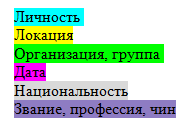

Пришлось сохранить word как html и парсить уже его

### HTML parsing

#### lxml parsing
https://dev-gang.ru/article/kak-ispolzovat-python-i-xpath-dlja-czistki-saitov-ht13ju9mu8/

In [ ]:
!apt-get install python3-bs4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-chardet python3-html5lib python3-lxml python3-pkg-resources
  python3-six python3-webencodings
Suggested packages:
  python3-genshi python3-lxml-dbg python-lxml-doc python3-setuptools
The following NEW packages will be installed:
  python3-bs4 python3-chardet python3-html5lib python3-lxml
  python3-pkg-resources python3-six python3-webencodings
0 upgraded, 7 newly installed, 0 to remove and 40 not upgraded.
Need to get 1,448 kB of archives.
After this operation, 6,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-bs4 all 4.6.0-1 [67.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [98.8 kB

##### тестовый html  и тесты BeutifulSoup lxml html

In [ ]:
#word переведенный в HTML
"""
background:aqua;mso-fareast-language:RU'>Личность&nbsp;</span>
background:yellow;mso-fareast-language:RU'>Локация</span>
background:lime;mso-fareast-language:RU'>Организация, группа&nbsp;</span>
background:fuchsia;mso-fareast-language:RU'>Дата</span>
background:#D9D9D9;mso-fareast-language:RU'>Национальность</span>
background:#8E7CC3;mso-fareast-language:RU'>Звание, профессия, чин</span>
background:white'  все остальное
"""
test = """
<html xmlns:v="urn:schemas-microsoft-com:vml"
xmlns:o="urn:schemas-microsoft-com:office:office"
xmlns:w="urn:schemas-microsoft-com:office:word"
xmlns:m="http://schemas.microsoft.com/office/2004/12/omml"
xmlns="http://www.w3.org/TR/REC-html40">

<head>
<meta http-equiv=Content-Type content="text/html; charset=windows-1251">
<meta name=ProgId content=Word.Document>
<meta name=Generator content="Microsoft Word 12">
<meta name=Originator content="Microsoft Word 12">
<title> TITLE </title>
</head
<body>
<link rel=File-List href="База%20новостеи&#774;%20часть%201.files/filelist.xml">
<p class=MsoNormal style='margin-top:12.0pt;margin-right:0cm;margin-bottom:
0cm;margin-left:0cm;margin-bottom:.0001pt;text-indent:0cm;background:white'><span
style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";background:
aqua;mso-fareast-language:RU'>Личность&nbsp;</span><span style='font-size:12.0pt;
mso-fareast-font-family:"Times New Roman";color:windowtext;mso-fareast-language:
RU'><o:p></o:p></span></p>

<p class=MsoNormal style='margin:0cm;margin-bottom:.0001pt;text-indent:0cm;
background:white'><span style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";
background:yellow;mso-fareast-language:RU'>Локация</span><span
style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";color:windowtext;
mso-fareast-language:RU'><o:p></o:p></span></p>

<p class=MsoNormal style='margin:0cm;margin-bottom:.0001pt;text-indent:0cm;
background:white'><span style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";
background:lime;mso-fareast-language:RU'>Организация, группа&nbsp;</span><span
style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";color:windowtext;
mso-fareast-language:RU'><o:p></o:p></span></p>

<p class=MsoNormal style='margin:0cm;margin-bottom:.0001pt;text-indent:0cm;
background:white'><span style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";
background:fuchsia;mso-fareast-language:RU'>Дата</span><span style='font-size:
12.0pt;mso-fareast-font-family:"Times New Roman";color:windowtext;mso-fareast-language:
RU'><o:p></o:p></span></p>

<p class=MsoNormal style='margin:0cm;margin-bottom:.0001pt;text-indent:0cm;
background:white'><span style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";
background:#D9D9D9;mso-fareast-language:RU'>Национальность</span><span
style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";color:windowtext;
mso-fareast-language:RU'><o:p></o:p></span></p>

<p class=MsoNormal style='margin:0cm;margin-bottom:.0001pt;text-indent:0cm;
background:white'><span style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";
background:#8E7CC3;mso-fareast-language:RU'>Звание, профессия, чин</span><span
style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";color:windowtext;
mso-fareast-language:RU'><o:p></o:p></span></p>

<p class=MsoNormal style='margin-top:0cm;margin-right:0cm;margin-bottom:12.0pt;
margin-left:0cm;text-indent:0cm;background:white'><span style='font-size:12.0pt;
mso-fareast-font-family:"Times New Roman";color:windowtext;mso-fareast-language:
RU'>&nbsp;<o:p></o:p></span></p>

<!--<ol style='margin-top:0cm' start=1 type=1>-->
 <li class=MsoNormal style='margin-top:12.0pt;margin-right:0cm;margin-bottom:
     0cm;margin-left:36.0pt;margin-bottom:.0001pt;text-indent:-18.0pt;
     mso-list:l0 level1 lfo1;tab-stops:list 36.0pt;background:white;vertical-align:
     baseline'><span style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";
     mso-fareast-language:RU'>В аппарате главы <span style='background:lime'>МИД</span>
     <span style='background:yellow'>Бельгии</span> <span style='background:
     aqua'>Дидье Рейндерса</span> подтвердили сообщения о том, что он внес свою
     кандидатуру на пост <span style='background:#8E7CC3'>генсека Совета Европы</span>,
     выборы которого намечены на <span style='background:fuchsia'>июнь этого
     года</span>. <span style='background:fuchsia'>Ранее</span>
     телерадиокомпания<span style='background:lime'> VRT</span> со ссылкой на
     источники сообщила, что <span style='background:#8E7CC3'>вице-премьер,
     глава МИД </span><span style='background:yellow'>Бельгии</span> <span
     style='background:aqua'>Дидье Рейндерс</span> может претендовать на пост <span
     style='background:#8E7CC3'>нового генсека Совета Европы</span>. &quot;Эта
     корректная информация&quot;, - сказал в <span style='background:fuchsia'>понедельник</span>
     <span style='background:lime'>РИА Новости</span> <span style='background:
     #8E7CC3'>представитель пресс-службы министра</span>, не уточнив других
     деталей. <span style='background:#8E7CC3'>Глава бельгийского МИД</span>
     неоднократно посещал <span style='background:yellow'>РФ</span> <span
     style='background:fuchsia'>в последние годы</span>, в том числе в рамках
     прошедшего <span style='background:fuchsia'>этим летом</span> чемпионата
     мира по футболу, в своих высказываниях относительно отношений <span
     style='background:lime'>ЕС</span> с <span style='background:yellow'>Москвой</span>
     в целом выступал с позиций необходимости продолжения диалога и поиска
     решений самых сложных вопросов. <span style='background:fuchsia'>Ранее</span>
     <span style='background:#8E7CC3'>глава МИД РФ</span> <span
     style='background:aqua'>Сергей Лавров</span> заявлял, что момент истины
     для отношений <span style='background:yellow'>России </span>и <span
     style='background:lime'>Совета Европы</span> наступит <span
     style='background:fuchsia'>в июне 2019 года</span>, когда будет избираться
     <span style='background:#8E7CC3'>генсек организации</span>. <span
     style='background:#8E7CC3'>Нынешний генсек СЕ</span> <span
     style='background:aqua'>Турбьерн Ягланд</span> ранее заявил, что
     &quot;если <span style='background:yellow'>Россия </span>не начнет платить
     взносы в бюджет <span style='background:lime'>Совета Европы</span> <span
     style='background:fuchsia'>до июня 2019 года</span>, комитет министров
     организации не только может, но и будет обязан исключить ее из списка
     стран-членов&quot;.<o:p></o:p></span></li>
  <li class=MsoNormal style='margin-top:0cm;margin-right:0cm;margin-bottom:0cm;
     margin-left:36.0pt;margin-bottom:.0001pt;text-indent:-18.0pt;mso-list:
     l0 level1 lfo1;tab-stops:list 36.0pt;background:white;vertical-align:baseline'><span
     class=GramE><span style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";
     background:#8E7CC3;mso-fareast-language:RU'>Лингвист</span><span
     style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";
     mso-fareast-language:RU'> <span style='background:aqua'>Герард Чешир
     (Gerard Cheshire)</span> из <span style='background:lime'>Бристольского
     университета</span> (<span style='background:yellow'>Великобритания</span>)
     заявил, что ему удалось прочесть загадочный манускрипт <span
     style='background:aqua'>Войнича</span>: он написан на одном из народных
     диалектов романских языков, который впоследствии бесследно исчез.</span></span><span
     style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";
     mso-fareast-language:RU'> Выводы <span style='background:#8E7CC3'>ученого</span>
     опубликованы в журнале <span style='background:lime'>Romance Studies</span>.
     &quot;Манускрипт написан на протороманском языке — предке тех диалектов
     этой языковой семьи, на которых сейчас говорят в <span style='background:
     yellow'>Португалии, Франции, Испании </span>и других странах. Его
     повсеместно использовали в <span style='background:yellow'>Средиземноморье
     </span>в средние века, но на нем почти никто не писал, так как латынь
     оставалась языком знати, церкви и государства. Поэтому этот язык бесследно
     исчез&quot;, — заявил<span style='background:#8E7CC3'> ученый</span>. Так
     называемый манускрипт <span style='background:aqua'>Войнича</span>, одну
     из самых загадочных средневековых рукописей, обнаружил в <span
     style='background:fuchsia'>1912 </span>году <span style='background:#D9D9D9'>польский</span>
     <span style='background:#8E7CC3'>книготорговец</span> <span
     style='background:aqua'>Уилфрид Войнич</span> среди томов, купленных на
     распродаже в <span style='background:lime'>Римской коллегии (академ<span
     class=GramE>ии ие</span>зуитов)</span>. Этот текст, написанный непонятными
     символами на непонятном языке, практически сразу привлек внимание самых
     разных <span style='background:#8E7CC3'>ученых</span> — от <span
     style='background:#8E7CC3'>лингвистов и историков до физиков и
     программистов</span>. Большинство <span style='background:#8E7CC3'>исследователей</span>
     предполагают, что манускрипт представляет собой некую шифровку, и десятки
     научных групп пытаются расшифровать его при помощи как систем
     искусственного интеллекта, так и методов исторических наук.<o:p></o:p></span></li>
 <li class=MsoNormal style='margin-top:0cm;margin-right:0cm;margin-bottom:0cm;
     margin-left:36.0pt;margin-bottom:.0001pt;text-indent:-18.0pt;mso-list:
     l0 level1 lfo1;tab-stops:list 36.0pt;background:white;vertical-align:baseline'><span
     style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";
     background:#8E7CC3;mso-fareast-language:RU'>Спецпредставитель президента</span><span
     style='font-size:12.0pt;mso-fareast-font-family:"Times New Roman";
     mso-fareast-language:RU'> <span style='background:yellow'>России </span>по
     <span style='background:yellow'>Сирии </span><span style='background:aqua'>Александр
     Лаврентьев</span> и <span style='background:#8E7CC3'>замминистра</span> иностранных
     дел <span style='background:aqua'>Сергей Вершинин</span> обсудили с <span
     style='background:#8E7CC3'>советником премьер-министра</span> <span
     style='background:yellow'>Великобритании </span>по международным делам, <span
     style='background:#8E7CC3'>заместителем советника премьер-министра</span> <span
     style='background:yellow'>Великобритании </span>по вопросам национальной
     безопасности <span style='background:aqua'>Кристианом Тёрнером</span>
     ситуацию на <span style='background:yellow'>Ближнем Востоке</span>, в том
     числе в <span style='background:yellow'>Сирии</span>, сообщил <span
     style='background:lime'>МИД</span> <span style='background:yellow'>РФ</span>.
     Встреча прошла в <span style='background:fuchsia'>среду</span>.
     Вооруженный конфликт в <span style='background:yellow'>Сирии </span>продолжается
     с <span style='background:fuchsia'>2011</span> года. В конце <span
     style='background:fuchsia'>2017</span> года было объявлено о победе над
     запрещенной в <span style='background:yellow'>РФ </span>террористической
     группировкой &quot;<span style='background:lime'>Исламское государство</span>&quot;*
     в <span style='background:yellow'>Сирии и Ираке</span>. В отдельных
     районах <span style='background:yellow'>САР </span>продолжаются зачистки
     от <span style='background:#8E7CC3'>боевиков</span>. В настоящий момент на
     первый план выступает политическое урегулирование, восстановление <span
     style='background:yellow'>Сирии</span>, а также возвращение <span
     style='background:#8E7CC3'>беженцев</span>.<o:p></o:p></span></li>
</body>
     """

In [ ]:
soup = BeautifulSoup(test, 'html.parser')
print(soup.find('li').get_text())

В аппарате главы МИД
Бельгии Дидье Рейндерса подтвердили сообщения о том, что он внес свою
     кандидатуру на пост генсека Совета Европы,
     выборы которого намечены на июнь этого
     года. Ранее
     телерадиокомпания VRT со ссылкой на
     источники сообщила, что вице-премьер,
     глава МИД Бельгии Дидье Рейндерс может претендовать на пост нового генсека Совета Европы. "Эта
     корректная информация", - сказал в понедельник
РИА Новости представитель пресс-службы министра, не уточнив других
     деталей. Глава бельгийского МИД
     неоднократно посещал РФ в последние годы, в том числе в рамках
     прошедшего этим летом чемпионата
     мира по футболу, в своих высказываниях относительно отношений ЕС с Москвой
     в целом выступал с позиций необходимости продолжения диалога и поиска
     решений самых сложных вопросов. Ранее
глава МИД РФ Сергей Лавров заявлял, что момент истины
     для отношений России и Совета Европы наступит в июне 2019 года, когда будет избираться
     генсе

In [ ]:
from lxml import html
from bs4 import BeautifulSoup
tree = html.fromstring(test)
#with open(pathNameData + "news/База новостей часть 1.htm") as fp:
#with open(pathNameData + "news/База новостей часть 1.htm",  encoding="utf8", errors='ignore') as fp:
#    tree = BeautifulSoup(fp, 'html.parser')

#tree1 = tree.body
tags_color = []
el_p = tree.xpath('//p/span[@style]') 
#el_p = tree1.xpath('//p/span') 
for el in el_p:
  if el.text:
    text = el.text.replace("\n","").replace(u'\xa0', '')
    if text:
      #print(el.text ) #  if el.text else False
      style = el.attrib["style"].replace("\n","").replace(u'\xa0', '')
      pos = style.find("background:")
      if pos>-1 :
        pos2 = style.find(";", pos + len("background:"))
        #print(style[pos + len("background:"): pos2])
        color = style[pos + len("background:"): pos2]
      else:
        color = "white"
      tags_color.append([el.text.replace("\n","").replace(u'\xa0', ''), color])

for tag in tags_color:
  tag[0].replace("\xa0", '')
  tag[1].replace("\xa0", '')
print(tags_color)
tags_color.append(['Misc',"white"])
print(tags_color)
#set_tags = set(tags_color[0])
#print(set_tags)
t_colors = [tag[1] for tag in tags_color]
t_tags = [tag[0] for tag in tags_color]
print(t_colors)
print(t_tags)
t_tags2 = ["PER", "LOC", "ORG", "DATE", "NATIONALITY", "JOB", "MISC"]
print(t_tags2)

[['Личность', 'aqua'], ['Локация', 'yellow'], ['Организация, группа', 'lime'], ['Дата', 'fuchsia'], ['Национальность', '#D9D9D9'], ['Звание, профессия, чин', '#8E7CC3']]
[['Личность', 'aqua'], ['Локация', 'yellow'], ['Организация, группа', 'lime'], ['Дата', 'fuchsia'], ['Национальность', '#D9D9D9'], ['Звание, профессия, чин', '#8E7CC3'], ['Misc', 'white']]
['aqua', 'yellow', 'lime', 'fuchsia', '#D9D9D9', '#8E7CC3', 'white']
['Личность', 'Локация', 'Организация, группа', 'Дата', 'Национальность', 'Звание, профессия, чин', 'Misc']
['PER', 'LOC', 'ORG', 'DATE', 'NATIONALITY', 'JOB', 'MISC']


#### parsing v2.0
https://dev-gang.ru/article/kak-ispolzovat-python-i-xpath-dlja-czistki-saitov-ht13ju9mu8/

In [ ]:
# выделяеи цвета фона для определения тэгов

from lxml import html
from bs4 import BeautifulSoup
#soup = BeautifulSoup(test, 'html.parser')
with open(pathNameData + "news/База новостей часть 1.htm",  encoding="cp1251", errors='ignore') as fp:
# в файле HTML, сгенерированным MS Word, -  charset=windows-1251  
    tree = BeautifulSoup(fp, 'html.parser')
tree1 = tree.body
test = tree.body.prettify() # для исключения ошибок
tree2= BeautifulSoup(test, 'html.parser')
tree1 = tree2.body
tags_color = []
pspans = tree1.find_all('p') #, {'style':"background:lime"})
for i,el1 in enumerate(pspans):
  #print(el1.getText())
  el = str(el1)
  if el:
    text = el.replace("\n","").replace(u'\xa0', '').strip()
    if text:
      #print(el.text ) #  if el.text else False
      pos = text.find("background:") # первоначально это бэкграунд класса
      # для файла перенсенного руками в тестовую строку этого достаточно
      # для обработки из файла нужна еще одна строка
      pos = text.find("background:", pos+1)
      if pos>-1 :
        pos2 = text.find(";", pos + len("background:"))
        #pos2 = text.find('">', pos + len("background:"))
        color = text[pos + len("background:"): pos2]
        #print(pos, pos2, color)
      else:
        color = "white"

      text_tag = el1.get_text().replace("\n","").replace(u'\xa0', '').strip()
      if len (text_tag) > 0:
        if [text_tag, color] not in tags_color:
          tags_color.append([text_tag, color])
  if i>13:
    break
for tag in tags_color:
  tag[0].replace("\n","").replace(u'\xa0', '').strip()
  tag[1].replace("\n","").replace(u'\xa0', '').strip()
print(tags_color)
tags_color.append(['Misc',"white"])
print(tags_color)
t_colors = [tag[1] for tag in tags_color]
t_tags = [tag[0] for tag in tags_color]
print(t_colors)
print(t_tags)


[['Личность', 'aqua'], ['Локация', 'yellow'], ['Организация, группа', 'lime'], ['Дата', 'fuchsia'], ['Национальность', '#D9D9D9'], ['Звание, профессия, чин', '#8E7CC3']]
[['Личность', 'aqua'], ['Локация', 'yellow'], ['Организация, группа', 'lime'], ['Дата', 'fuchsia'], ['Национальность', '#D9D9D9'], ['Звание, профессия, чин', '#8E7CC3'], ['Misc', 'white']]
['aqua', 'yellow', 'lime', 'fuchsia', '#D9D9D9', '#8E7CC3', 'white']
['Личность', 'Локация', 'Организация, группа', 'Дата', 'Национальность', 'Звание, профессия, чин', 'Misc']


In [ ]:
t_tags2 = ["PER", "LOC", "ORG", "DATE", "NATIONALITY", "JOB", "MISC"]
print(t_tags2)
colors_name_lens = [len(t) for t in t_colors]
max_colors_name_len = max(colors_name_lens)
print(max_colors_name_len)

['PER', 'LOC', 'ORG', 'DATE', 'NATIONALITY', 'JOB', 'MISC']
7


In [ ]:
def make_tag_lookup_table2():
    iob_labels = ["B", "I"]
    ner_labels = ["PER", "ORG", "LOC", "DATE", "NATIONALITY", "JOB", "MISC"]
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    all_labels = ["[PAD]", "O"] + all_labels
    #all_labels = ["PAD", "O"] + all_labels
    t = zip(range(0, len(all_labels)), all_labels)
    return dict(zip(range(0, len(all_labels) + 1), all_labels))
    #return t
    #return all_labels

In [ ]:
mapping2 = make_tag_lookup_table2()
print(len(mapping2), mapping2)

16 {0: '[PAD]', 1: 'O', 2: 'B-PER', 3: 'I-PER', 4: 'B-ORG', 5: 'I-ORG', 6: 'B-LOC', 7: 'I-LOC', 8: 'B-DATE', 9: 'I-DATE', 10: 'B-NATIONALITY', 11: 'I-NATIONALITY', 12: 'B-JOB', 13: 'I-JOB', 14: 'B-MISC', 15: 'I-MISC'}


In [ ]:
# доп цвета/теги
add_color = ["#674EA7"]
#add_color_tags = ["JOB"]
add_color_tags = ['Звание, профессия, чин']


In [ ]:
#tree = html.fromstring(test)
with open(pathNameData + "news/База новостей часть 1.htm",  encoding="cp1251", errors='ignore') as fp:
    tree = BeautifulSoup(fp, 'html.parser')

tree1 = tree.body
test = tree.body.prettify() # для исключения ошибок по не очень хорошо сгенерированному HTML
tree2= BeautifulSoup(test, 'html.parser')
tree1 = tree2.body

li_s = tree1.find_all('li')
print("количество li", len(li_s))
max_li = len(li_s)
record = []
records = []
for i_li, li in enumerate(li_s):
  if i_li > max_li:  # Для пробы яуть поменьше
    break
  spans = li.find_all('span')
  print("Количество span", len(spans))

  last_t_tag = ''
  
  #for s in spans: # Это работало для строки но не для файла
  for s in spans[0]:

    #print(s, "\n")
    ss= str(s).replace("\xa0", '').replace("\n", '').strip()
    ss = ' '.join(ss.split()) # убираем лишние внутренние пробелы
    if ss: 
      if 'background:' in ss:  
        pos = ss.find("background:")
        pos2 = ss.find('"', pos + len("background:"))
        if pos2<0:
          #print("pos2<0",pos2, ss)
          pos2 = ss.find(';', pos + len("background:"))
        if (pos2-pos-len("background:")) > max_colors_name_len: # где-то ошибка или выялен цвет через #FFFFFF значение без кавычек
          #print(pos,pos2)
          #pos2 = pos + len("background:") + len("#FFFFFF") + 1
          pos2 = ss.find(';', pos + len("background:"))
          #print("new", pos,pos2)
        s_tag = ss[pos+len("background:"):pos2].replace("\xa0", '').replace("\n", '').strip()
        if len(s_tag)>10:
          print("s_tag:", s_tag) #, t_tags[t_colors.index(s_tag)], ss) 
        
        toc = s.get_text().replace("\xa0", '').replace("\n", '').strip()
        #print(s_tag,"-", t_tags[t_colors.index(s_tag)],': "', toc,'"', sep='' )
        tocs = toc.split()
        try:
          t_tag = t_tags[t_colors.index(s_tag)]
        except:
          try:
            t_tag = add_color_tags[add_color.index(s_tag)]
            #print("добавлен", s_tag, t_tag, "из add_color_tags")
          except:  
            #674EA7
            print(s_tag, "\n not in t_colors")
            print(ss)
            break
        t_tag2 = t_tags2[t_tags.index(t_tag)]
        t_tag3 = []
        first = True
        for toc in tocs:
          if first:
            first = False
            if last_t_tag != "Misc":
              t_tag3.append("B-" + t_tags2[t_tags.index(t_tag)])
              last_t_tag = t_tag
            else:
              t_tag3.append("I-" + t_tags2[t_tags.index(t_tag)])
              last_t_tag = t_tag
          else:
            t_tag3.append("I-" + t_tags2[t_tags.index(t_tag)])
            last_t_tag = t_tag
        
        print(s_tag,"-", t_tag,",", t_tag2, ': "', list(zip(tocs,t_tag3)), '"', sep='' )
        
        record.extend(list(zip(tocs,t_tag3)))
        
      else:
        s_tag = "white"
        t_tag = "Misc"
        t_tag2 = mapping2[0]
        toc =  ss.replace("\xa0", '').replace("\n", '').replace('<o:p></o:p>',"").strip()
        # попадается еще служебные символы в тексте '<o:p></o:p>'
        #toc =  s.get_text().replace("\xa0", '').replace("\n", '').replace('<o:p></o:p>',"").strip()
        
        #print(s_tag, "-", t_tag, ': "', toc ,'"', sep='' )
        
        tocs = toc.split()
        tocs = [toc for toc in tocs if len(toc) >0]
        # пропускаем пустые строки
        t_tag3 = [mapping2[0] for i in range(len(tocs))]
        
        if len(list(zip(tocs,t_tag3)))>0:
          #print(ss)
          print(s_tag, "-", t_tag, ",", t_tag2, ': "', list(zip(tocs,t_tag3))  ,'"\n', sep='' )
          last_t_tag = t_tag
          record.extend(list(zip(tocs,t_tag3)))
          #print("last_token- (record[-1][0])",record[-1][0])
          if record[-1][0] == "." or record[-1][0][-1] == "." : 
            # последний токен record[-1] равен '.' или последний символ последнего токена record[-1][-1] равен ".' запись сфорирована 
            records.append(record)
            record = []
    
print(len(records), records[0])

Выходные данные были обрезаны до нескольких последних строк (5000).
#8E7CC3-Звание, профессия, чин,JOB: "[('председателя', 'I-JOB')]"
lime-Организация, группа,ORG: "[('Центристской', 'B-ORG'), ('партии', 'I-ORG')]"
aqua-Личность,PER: "[('Эдгара', 'B-PER')]"
aqua-Личность,PER: "[('Сависаара', 'B-PER')]"
white-Misc,[PAD]: "[('перевели', '[PAD]'), ('на', '[PAD]'), ('домашнее', '[PAD]'), ('лечение,', '[PAD]'), ('сообщила', '[PAD]'), ('в', '[PAD]'), ('четверг', '[PAD]'), ('пресс-служба', '[PAD]'), ('партии.', '[PAD]'), ('"', '[PAD]')]"

aqua-Личность,PER: "[('Сависаар', 'I-PER')]"
white-Misc,[PAD]: "[('в', '[PAD]')]"

fuchsia-Дата,DATE: "[('четверг', 'I-DATE')]"
white-Misc,[PAD]: "[('был', '[PAD]'), ('выписан', '[PAD]'), ('из', '[PAD]'), ('таллиннской', '[PAD]'), ('больницы', '[PAD]')]"

yellow-Локация,LOC: "[('Магдалена', 'I-LOC')]"
white-Misc,[PAD]: "[('.', '[PAD]'), ('Его', '[PAD]'), ('отвезли', '[PAD]'), ('домой', '[PAD]'), ('на', '[PAD]'), ('хутор', '[PAD]')]"

yellow-Локация,LOC: "[('

In [ ]:
# доп цвета/теги для train_dataset doc1
add_color = ["#674EA7"]
#add_color_tags = ["JOB"]
add_color_tags = ['Звание, профессия, чин']


In [ ]:
# доп цвета/теги
add_color.append("#EFEFEF")
add_color.append("#8E7CC3")
add_color_tags.append ('Национальность')
add_color_tags.append ('Звание, профессия, чин')
print(add_color)
print(add_color_tags)

['#674EA7', '#EFEFEF', '#8E7CC3']
['Звание, профессия, чин', 'Национальность', 'Звание, профессия, чин']


## Create dataset

In [ ]:
all_tokens2 = [ann_tok[0]  for rec in records for ann_tok in rec]
print(len(all_tokens2), all_tokens2[:10])
all_tags2 = [ann_tok[1]  for rec in records for ann_tok in rec]
print(all_tags2[:10])

72530 ['В', 'аппарате', 'главы', 'МИД', 'Бельгии', 'Дидье', 'Рейндерса', 'подтвердили', 'сообщения', 'о']
['[PAD]', '[PAD]', '[PAD]', 'I-ORG', 'B-LOC', 'B-PER', 'I-PER', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
#all_tokens = sum(conll_data["train"]["tokens"], [])
all_tokens_array2 = np.array(all_tokens2)
print("all_tokens", len(all_tokens_array2))
counter2 = Counter(all_tokens_array2)
print("counter2", len(counter2))

num_tags2 = len(mapping2)
vocab_size2 = 20000

# We only take (vocab_size - 2) most commons words from the training data since
# the `StringLookup` class uses 2 additional tokens - one denoting an unknown
# token and another one denoting a masking token
vocabulary2 = [token for token, count in counter2.most_common(vocab_size2 - 2)]

# The StringLook class will convert tokens to token IDs
lookup_layer2 = keras.layers.StringLookup(
    vocabulary=vocabulary2
)

all_tokens 72530
counter2 21890


In [ ]:
xData, yData = [],[]
#xData2, yData2 = tf.TensorArray(tf.string), tf.TensorArray(tf.int64, size=(len()))
for rec in records:
  xData.append([])
  yData.append([])
  
  for ann_tock in rec:
    xData[-1].append(ann_tock[0])
    yData[-1].append(list(mapping2.values()).index(ann_tock[1]))
    #yData[-1] +=1
  #xData[-1] = np.array(xData[-1])
  #yData[-1] = np.array(yData[-1])
  #yData[-1] += 1

#xData = np.array(xData)
#yData = np.array(yData)  
print(xData[0])
print(yData[0])

['В', 'аппарате', 'главы', 'МИД', 'Бельгии', 'Дидье', 'Рейндерса', 'подтвердили', 'сообщения', 'о', 'том,', 'что', 'он', 'внес', 'свою', 'кандидатуру', 'на', 'пост', 'генсека', 'Совета', 'Европы', ',', 'выборы', 'которого', 'намечены', 'на', 'июнь', 'этого', 'года', '.']
[0, 0, 0, 5, 6, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 13, 13, 0, 0, 0, 0, 0, 9, 9, 9, 0]


In [ ]:
#print([xData,yData][0][0], ",\n", [xData,yData][0][1])
#print(records3[0], "\n", records3[1])
for i,record in enumerate(zip(xData, yData)):
  print (record[0], "\n", record[1])
  if i>5:
    break

['В', 'аппарате', 'главы', 'МИД', 'Бельгии', 'Дидье', 'Рейндерса', 'подтвердили', 'сообщения', 'о', 'том,', 'что', 'он', 'внес', 'свою', 'кандидатуру', 'на', 'пост', 'генсека', 'Совета', 'Европы', ',', 'выборы', 'которого', 'намечены', 'на', 'июнь', 'этого', 'года', '.'] 
 [0, 0, 0, 5, 6, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 13, 13, 0, 0, 0, 0, 0, 9, 9, 9, 0]
['Ранее', 'телерадиокомпания', 'VRT', 'со', 'ссылкой', 'на', 'источники', 'сообщила,', 'что', 'вице-премьер,', 'глава', 'МИД', 'Бельгии', 'Дидье', 'Рейндерс', 'может', 'претендовать', 'на', 'пост', 'нового', 'генсека', 'Совета', 'Европы', '.', '"Эта', 'корректная', 'информация",', '-', 'сказал', 'в', 'понедельник', 'РИА', 'Новости', 'Власти', 'Бельгии', 'отказались', 'последовать', 'призыву', 'Еврокомиссии', 'и', 'принять', 'в', 'стране', 'нелегальных', 'мигрантов', 'с', 'борта', 'двух', 'кораблей', 'германских', 'НПО,', 'находящихся', 'в', 'территориальных', 'водах', 'Мальты', '.', 'Как', 'сообщил', 'журналистам', 'представ

In [ ]:
print(list(zip(xData,yData))[0])

(['В', 'аппарате', 'главы', 'МИД', 'Бельгии', 'Дидье', 'Рейндерса', 'подтвердили', 'сообщения', 'о', 'том,', 'что', 'он', 'внес', 'свою', 'кандидатуру', 'на', 'пост', 'генсека', 'Совета', 'Европы', ',', 'выборы', 'которого', 'намечены', 'на', 'июнь', 'этого', 'года', '.'], [0, 0, 0, 5, 6, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 13, 13, 0, 0, 0, 0, 0, 9, 9, 9, 0])


In [ ]:
#Ok
def export_to_file2(export_file_path, data):
    with open(export_file_path, "w") as f:
        for i, record in enumerate(data):
            if i>1:
              break
            ner_tags = record[1]
            tokens = record[0]
            #print(len(tokens), tokens)
            f.write(
                str(len(tokens))
                + "\t"
                + "\t".join(tokens)
                #+ "\t".join(tokens).encode('utf-8')
                + "\t"
                + "\t".join(map(str, ner_tags))
                + "\n",

            )

import os
if os.path.isdir("data"):
  print("dir 'data' exist")
else:
  os.mkdir("data")
#export_to_file("./data/conll_train.txt", conll_data["train"])
#export_to_file("./data/conll_val.txt", conll_data["validation"])
export_to_file2("./data/rus_train.txt", list(zip(xData,yData)))

dir 'data' exist


In [ ]:
#Ok
train_data2 = tf.data.TextLineDataset("./data/rus_train.txt")
#val_data = tf.data.TextLineDataset("./data/conll_val.txt")

In [ ]:
print(str(list(train_data2.take(1).as_numpy_iterator())))
#.decode('utf-8') для byte Прдеставления строк
print(list(train_data2.take(1).as_numpy_iterator())[0].decode('utf-8'))

[b'30\t\xd0\x92\t\xd0\xb0\xd0\xbf\xd0\xbf\xd0\xb0\xd1\x80\xd0\xb0\xd1\x82\xd0\xb5\t\xd0\xb3\xd0\xbb\xd0\xb0\xd0\xb2\xd1\x8b\t\xd0\x9c\xd0\x98\xd0\x94\t\xd0\x91\xd0\xb5\xd0\xbb\xd1\x8c\xd0\xb3\xd0\xb8\xd0\xb8\t\xd0\x94\xd0\xb8\xd0\xb4\xd1\x8c\xd0\xb5\t\xd0\xa0\xd0\xb5\xd0\xb9\xd0\xbd\xd0\xb4\xd0\xb5\xd1\x80\xd1\x81\xd0\xb0\t\xd0\xbf\xd0\xbe\xd0\xb4\xd1\x82\xd0\xb2\xd0\xb5\xd1\x80\xd0\xb4\xd0\xb8\xd0\xbb\xd0\xb8\t\xd1\x81\xd0\xbe\xd0\xbe\xd0\xb1\xd1\x89\xd0\xb5\xd0\xbd\xd0\xb8\xd1\x8f\t\xd0\xbe\t\xd1\x82\xd0\xbe\xd0\xbc,\t\xd1\x87\xd1\x82\xd0\xbe\t\xd0\xbe\xd0\xbd\t\xd0\xb2\xd0\xbd\xd0\xb5\xd1\x81\t\xd1\x81\xd0\xb2\xd0\xbe\xd1\x8e\t\xd0\xba\xd0\xb0\xd0\xbd\xd0\xb4\xd0\xb8\xd0\xb4\xd0\xb0\xd1\x82\xd1\x83\xd1\x80\xd1\x83\t\xd0\xbd\xd0\xb0\t\xd0\xbf\xd0\xbe\xd1\x81\xd1\x82\t\xd0\xb3\xd0\xb5\xd0\xbd\xd1\x81\xd0\xb5\xd0\xba\xd0\xb0\t\xd0\xa1\xd0\xbe\xd0\xb2\xd0\xb5\xd1\x82\xd0\xb0\t\xd0\x95\xd0\xb2\xd1\x80\xd0\xbe\xd0\xbf\xd1\x8b\t,\t\xd0\xb2\xd1\x8b\xd0\xb1\xd0\xbe\xd1\x80\xd1\x8b\t\xd0\xba\

In [ ]:
print(b'\xd0\x92'.decode("utf-8") )
print(b'\xd0\xb0\xd0\xbf\xd0\xbf\xd0\xb0\xd1\x80\xd0\xb0\xd1\x82\xd0\xb5'.decode("utf-8"))

В
аппарате


In [ ]:
all_tokens_array2 [:5]

array(['В', 'аппарате', 'главы', 'МИД', 'Бельгии'], dtype='<U72')

In [ ]:
print(lookup_layer2(['В', 'аппарате', 'главы', 'МИД', 'Бельгии']))
print(lookup_layer2([b'\xd0\x92',
                     b'\xd0\xb0\xd0\xbf\xd0\xbf\xd0\xb0\xd1\x80\xd0\xb0\xd1\x82\xd0\xb5',
                     b'\xd0\xb3\xd0\xbb\xd0\xb0\xd0\xb2\xd1\x8b', 
                     b'\xd0\x9c\xd0\x98\xd0\x94',
                     b'\xd0\x91\xd0\xb5\xd0\xbb\xd1\x8c\xd0\xb3\xd0\xb8\xd0\xb8',
                     b'\xd0\x94\xd0\xb8\xd0\xb4\xd1\x8c\xd0\xb5'
                     ]))

tf.Tensor([  11 7464  115   35   83], shape=(5,), dtype=int64)
tf.Tensor([  11 7464  115   35   83 1702], shape=(6,), dtype=int64)


In [ ]:
#Ok
def map_record_to_training_data2(record):
    record = tf.strings.split(record, sep="\t")
    #print(record, "\n")
    #print(record[0], "\n")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    #print(length, len(record), record)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    tags += 1
    return tokens, tags


def lowercase_and_convert_to_ids2(tokens):
    tokens = tf.strings.lower(tokens)
    #print("tokens", tokens)
    return lookup_layer2(tokens)
    #return tokens


# We use `padded_batch` here because each record in the dataset has a
# different length.
#batch_size = 32
batch_size = 128
train_dataset2 = (
    train_data2.map(map_record_to_training_data2)
    .map(lambda x, y: (lowercase_and_convert_to_ids2(x), y))
    .padded_batch(batch_size)
)
"""
val_dataset = (
    val_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)
"""
#ner_model2 = NERModel(num_tags2, vocab_size2, embed_dim=32, num_heads=4, ff_dim=64)

'\nval_dataset = (\n    val_data.map(map_record_to_training_data)\n    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))\n    .padded_batch(batch_size)\n)\n'

In [ ]:
print(train_dataset2.take(1)  )
print(len(list(train_dataset2.take(1).as_numpy_iterator())[0]), len(list(train_dataset2.take(1).as_numpy_iterator())[0][0]), "\n",
      "tokens_ids:", len(list(train_dataset2.take(1).as_numpy_iterator())[0][0][0]), "\n", list(train_dataset2.take(1).as_numpy_iterator())[0][0][0][:16], "\n",
      #"\n", list(train_dataset2.take(1).as_numpy_iterator())[0][0][0][0].decode("utf-8"), list(train_dataset2.take(1).as_numpy_iterator())[0][0][0][1].decode("utf-8"), "\n",
      "tag_ids:", len(list(train_dataset2.take(1).as_numpy_iterator())[0][1][0]), "\n", list(train_dataset2.take(1).as_numpy_iterator())[0][1][0][:16],
      )

#print(list(train_dataset2.take(1).as_numpy_iterator()))

<TakeDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>
2 2 
 tokens_ids: 86 
 [  11 7464  115   35   83 1702 7465 1397 2177   13  154    7   48 7466
  178 2178] 
 tag_ids: 86 
 [1 1 1 6 7 3 4 1 1 1 1 1 1 1 1 1]


We will be using the transformer implementation from this fantastic
[example](https://keras.io/examples/nlp/text_classification_with_transformer/).

Let's start by defining a `TransformerBlock` layer:

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


Next, let's define a `TokenAndPositionEmbedding` layer:

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings


## Build the NER model class as a `keras.Model` subclass

In [ ]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32
    ):
        super(NERModel, self).__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x


In [ ]:
ner_model2 = NERModel(num_tags2, vocab_size2, embed_dim=32, num_heads=4, ff_dim=64)

In [ ]:
num_tags2, vocab_size2

(16, 20000)

In [ ]:
a= tf.constant(["rrr", "777"], dtype=tf.string, )
a

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'rrr', b'777'], dtype=object)>

In [ ]:
class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=keras.losses.Reduction.NONE
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


loss2 = CustomNonPaddingTokenLoss()

## Compile and fit the model

In [ ]:
num_tags2 = len(mapping2)
num_tags2, vocab_size2

(16, 20000)

In [ ]:
ner_model2 = NERModel(num_tags2, vocab_size2, embed_dim=32, num_heads=4, ff_dim=64)

In [ ]:
ner_model2.compile(optimizer="adam", loss=loss2)
#ner_model2.fit(xData, yData, epochs=10)
ner_model2.fit(train_dataset2, epochs=100)


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


1/1 [==============================] - 2s 2s/step - loss: 1.4724
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 1.3900
Epoch 3/100
1/1 [==============================] - 0s 22ms/step - loss: 1.2457
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 1.1697
Epoch 5/100
1/1 [==============================] - 0s 22ms/step - loss: 1.0907
Epoch 6/100
1/1 [==============================] - 0s 17ms/step - loss: 1.0469
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 0.9080
Epoch 8/100
1/1 [==============================] - 0s 24ms/step - loss: 0.8759
Epoch 9/100
1/1 [==============================] - 0s 20ms/step - loss: 0.7971
Epoch 10/100
1/1 [==============================] - 0s 19ms/step - loss: 0.7400
Epoch 11/100
1/1 [==============================] - 0s 20ms/step - loss: 0.7110
Epoch 12/100
1/1 [==============================] - 0s 26ms/step - loss: 0.6292
Epoch 13/100
1/1 [==============================] - 0s 18ms/ste

In [ ]:
def tokenize_and_convert_to_ids2(text):
    tokens = text.split()
    return lowercase_and_convert_to_ids2(tokens)

# Sample inference using the trained model
test_text = """ранее телерадиокомпания vrt со ссылкой на источники сообщила 
    что вице-премьер глава мид бельгии дидье рейндерс 
    может претендовать на пост нового генсека совета европы"""
sample_input = tokenize_and_convert_to_ids2(
    test_text
)
sample_input = tf.reshape(sample_input, shape=[1, -1])
print(sample_input)

output = ner_model2.predict(sample_input)
prediction = np.argmax(output, axis=-1)[0]
prediction = [mapping2[i] for i in prediction]

# eu -> B-ORG, german -> B-MISC, british -> B-MISC
print(test_text)
print(prediction)


tf.Tensor(
[[  224  1011     0    29   101     3   888    71     7 11160    69     0
      0     0     0    87  4250     3   172   223  1398   645     0]], shape=(1, 23), dtype=int64)
ранее телерадиокомпания vrt со ссылкой на источники сообщила 
    что вице-премьер глава мид бельгии дидье рейндерс 
    может претендовать на пост нового генсека совета европы
['B-NATIONALITY', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'B-MISC', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'B-MISC', 'B-MISC', 'B-MISC', 'B-LOC']


In [ ]:
vocabulary2

## Metrics calculation

Here is a function to calculate the metrics. The function calculates F1 score for the
overall NER dataset as well as individual scores for each NER tag.

In [ ]:
def calculate_metrics2(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        output = ner_model2.predict(x)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    predicted_tags = [mapping2[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping2[tag] for tag in all_true_tag_ids]

    evaluate(real_tags, predicted_tags)


In [ ]:
#calculate_metrics(val_dataset)
# Для упорщения сделаем на train_dataset2
calculate_metrics2(train_dataset2)

processed 116 tokens with 33 phrases; found: 33 phrases; correct: 33.
accuracy: 100.00%; (non-O)
accuracy: 100.00%; precision: 100.00%; recall: 100.00%; FB1: 100.00
             DATE: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              LOC: precision: 100.00%; recall: 100.00%; FB1: 100.00  6
             MISC: precision: 100.00%; recall: 100.00%; FB1: 100.00  12
      NATIONALITY: precision: 100.00%; recall: 100.00%; FB1: 100.00  5
              ORG: precision: 100.00%; recall: 100.00%; FB1: 100.00  4
              PER: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
